In [22]:
import pandas as pd
import plotly.express as px
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss, adfuller
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

import scipy.stats as scs
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import math
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import datetime as dt
import arch.data.sp500
import sys
from datetime import datetime, timedelta
from scipy.stats import pearsonr

## On importe nos données et on les affiche

In [23]:
data = pd.read_csv("cac40.csv")
data = data[["Date","Close"]]

for x in data[['Date']]:
    print(type(x))

data = data.set_index('Date')



data = data.dropna()

data = data.squeeze()


fig = px.line(data) #On créé une courbe 
fig.update_layout(title = "Prix de clôture de l'indice boursier au CAC 40",title_x = 0.45) #On lui donne un titre et on le centre
fig.show()

data = 100 * data.pct_change().dropna()



<class 'str'>


### On réindexe nos données puis on affiche nos données log-différencié

In [24]:
data.index = data.index.astype('datetime64[ns]')
data.index

DatetimeIndex(['1990-04-03', '1990-04-04', '1990-04-05', '1990-04-06',
               '1990-04-09', '1990-04-10', '1990-04-11', '1990-04-12',
               '1990-04-17', '1990-04-18',
               ...
               '2021-06-17', '2021-06-18', '2021-06-21', '2021-06-22',
               '2021-06-23', '2021-06-24', '2021-06-25', '2021-06-28',
               '2021-06-29', '2021-06-30'],
              dtype='datetime64[ns]', name='Date', length=7923, freq=None)

In [25]:
fig = px.line(data) #On créé une courbe 
fig.update_layout(title = "Prix de clôture de l'indice boursier au CAC 40 log-différencié",title_x = 0.5) #On lui donne un titre et on le centre
fig.show()

Test de stationnarités

In [26]:
TestA = adfuller(data) # Test ADF
print("ADF p-val : ", TestA[1]) 
TestK = kpss(data) # Test KPSS
print("KPSS p-val : ", TestK[1])

ADF p-val :  0.0
KPSS p-val :  0.1


c:\Users\thoma\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Tests disent que c'est stationnaire

### ACF - PACF

c:\Users\thoma\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



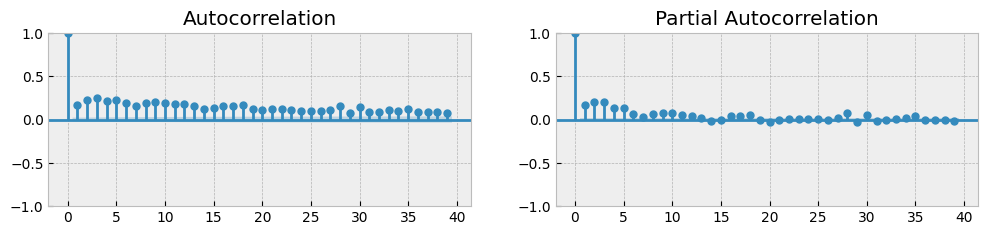

In [29]:
with plt.style.context("bmh"):
    fig = plt.figure(figsize=(12,2.25))
    layout = (1,2)
    acf_ax = plt.subplot2grid(layout, (0, 0), alpha=0.5)
    pacf_ax = plt.subplot2grid(layout, (0, 1), alpha=0.5)
    plot_acf(data**2, ax=acf_ax)
    plot_pacf(data**2, ax=pacf_ax) 
    plt.show()

On calcule les différents AIC pour des modèles GARCH

In [9]:
p=[1,2,3,4,5,6,7]
q=[0,1,2]
aic=pd.DataFrame(index=[1,2,3,4,5,6,7],columns=[0,1,2]) # declare un dataframe vide avec 7 lignes (pour les p)et 3 col (pour les q)

for i in range(1,8):
    for j in range(3):
        mod = arch_model(data, vol="Garch", p=i, q=j)
        res=mod.fit(disp="off")
        aic.loc[i,j]=res.aic

aic

,0,1,2
1,26951.443818,25187.615183,25189.615183
2,26349.354598,25180.167415,25181.835512
3,25864.743596,25182.167415,25180.308904
4,25638.751741,25184.167415,25182.308899
5,25503.224375,25186.167414,25184.308898
6,25402.039311,25188.167415,25184.303881
7,25359.312695,25190.167415,25186.303878


Le meilleur : garch(3,2) mais légèrement au dessus du garch(2,1)

Premier test avec un Garch(3,2)

In [34]:
p=2 ; q=1
mod = arch_model(data, vol="Garch", p=p, q=q)
res = mod.fit(disp="off")
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12585.1
Distribution:                  Normal   AIC:                           25180.2
Method:            Maximum Likelihood   BIC:                           25215.1
                                        No. Observations:                 7923
Date:                Wed, Mar 01 2023   Df Residuals:                     7922
Time:                        21:06:03   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0546  1.218e-02      4.479  7.507e-06 [3.068e-02,7.842e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0375  1.041e-02      3.605  3.121e-04 [1.713e-02,5.795e-02]
alpha[1]       0.0641  1.746e-02      3.671  2.421e-04 [2.986e-02,9.828e-02]
alpha[2]       0.0498  2.528e-02      1.971  4.868e-02 [2.887e-04,9.938e-02]
beta[1]        0.8672  2.116e-02     40.985      0.000     [  0.826,  0.909]
============================================================================

Covariance estimator: robust
"""

### Calcul des prédictions

In [35]:
mod_train = arch_model(data, vol="Garch", p=p, q=q)
res_train = mod_train.fit(disp="off", last_obs='2020-12-31')
res_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12435.5
Distribution:                  Normal   AIC:                           24881.0
Method:            Maximum Likelihood   BIC:                           24915.8
                                        No. Observations:                 7796
Date:                Wed, Mar 01 2023   Df Residuals:                     7795
Time:                        21:07:07   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0531  1.238e-02      4.287  1.811e-05 [2.881e-02,7.734e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0381  1.062e-02      3.586  3.356e-04 [1.727e-02,5.888e-02]
alpha[1]       0.0643  1.764e-02      3.643  2.691e-04 [2.969e-02,9.882e-02]
alpha[2]       0.0504  2.546e-02      1.979  4.781e-02   [4.866e-04,  0.100]
beta[1]        0.8666  2.119e-02     40.898      0.000     [  0.825,  0.908]
============================================================================

Covariance estimator: robust
"""

In [36]:
forecasts = res_train.forecast(start="2021-01-01", reindex=False)
prediction = forecasts.variance
prediction=prediction.rename(columns={"h.1":"Python"})
prediction

,Python
Date,
2021-01-04,0.982950
2021-01-05,0.924860
2021-01-06,0.934107
2021-01-07,0.938932
2021-01-08,0.895808
...,...
2021-06-24,0.726006
2021-06-25,0.738188
2021-06-28,0.747865


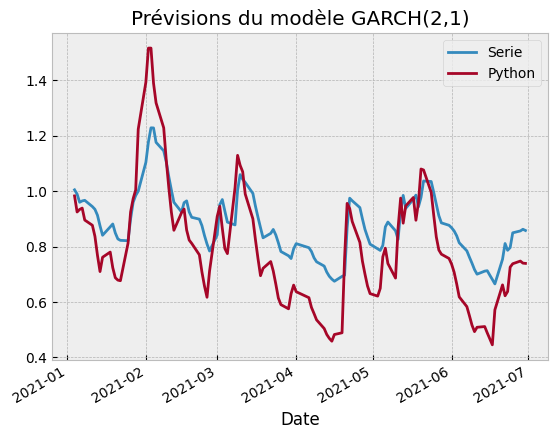

In [37]:
y_true=pd.DataFrame(res.conditional_volatility[-len(prediction):])
y_true=y_true.rename(columns={"cond_vol":"Serie"})

with plt.style.context("bmh"):
    fig=y_true.plot()
    prediction.plot(ax=fig)

    if q==0:
        plt.title(f"Prévisions du modèle ARCH({p})")
    else:
        plt.title(f"Prévisions du modèle GARCH({p},{q})")
    plt.show()

In [38]:
from sklearn.metrics import mean_squared_error
import math

MSE = mean_squared_error(y_true, prediction )
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:",RMSE)

Root Mean Square Error: 0.14362953706343176


In [39]:
def min_rmse(last_obs):
    rmse=pd.DataFrame(index=[1,2,3,4,5,6,7],columns=[0,1,2])

    last_obs = datetime.strptime(last_obs, "%Y-%m-%d")
    day_start=last_obs + timedelta(days=1)
    day_start= day_start.strftime("%Y-%m-%d")
    
    for p in range(1,8):
        for q in range(3):
            mod = arch_model(data, vol="Garch", p=p, q=q)
            res = mod.fit(disp="off")

            mod_train = arch_model(data, vol="Garch", p=p, q=q)
            res_train = mod_train.fit(disp="off", last_obs=last_obs)

            forecasts = res_train.forecast(start=day_start, reindex=False)
            prediction = forecasts.variance
            prediction=prediction.rename(columns={"h.1":"Python"})
            y_true= res.conditional_volatility[-len(prediction):]

            MSE = mean_squared_error(y_true, prediction )
            RMSE = math.sqrt(MSE)
            rmse.loc[p,q]=RMSE

    return rmse

min_rmse('2020-12-31')

,0,1,2
1,0.421608,0.14816,0.148157
2,0.332582,0.14363,0.144313
3,0.272027,0.143633,0.143821
4,0.23041,0.14363,0.149552
5,0.20785,0.143629,0.14382
6,0.192607,0.143627,0.151476
7,0.184817,0.143635,0.151476


Fonction Prédiction :

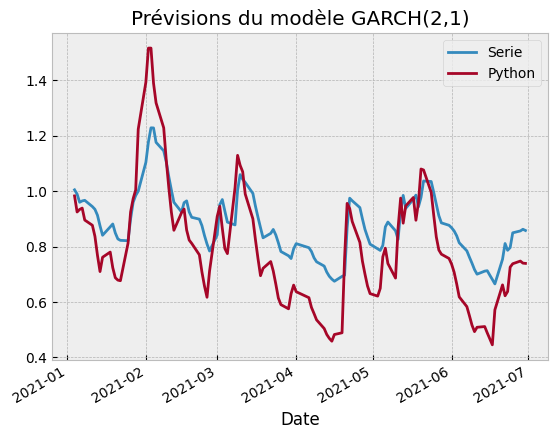

In [40]:
from code_projet import Prevision

p=2 ; q=1
last_obs='2020-12-31'
cond_var, y_true= Prevision(data, p,q).forecast_calcul(last_obs)

with plt.style.context("bmh"):
    fig=y_true.plot()
    pred=cond_var.drop(["Calculer"],axis=1)
    pred.plot(ax=fig)

    if q==0:
        plt.title(f"Prévisions du modèle ARCH({p})")
    else:
        plt.title(f"Prévisions du modèle GARCH({p},{q})")
    plt.show()

In [41]:
from code_projet import Prevision

def plot_modele(y_true, p, q, last_obs,ax):
    cond_var, y_true= Prevision(data, p,q).forecast_calcul(last_obs)
    cond_var["Serie"]=list(y_true["Serie"])
    cond_var.plot(ax=ax)

    if q==0:
        ax.set_title(f"Prévisions du modèle ARCH({p})")
    else:
        ax.set_title(f"Prévisions du modèle GARCH({p},{q})")

In [42]:
cond_var

,Python,Calculer
Date,,
2021-01-04,0.982950,0.979258
2021-01-05,0.924860,0.921985
2021-01-06,0.934107,0.936453
2021-01-07,0.938932,0.946053
2021-01-08,0.895808,0.900001
...,...,...
2021-06-24,0.726006,0.725291
2021-06-25,0.738188,0.739188
2021-06-28,0.747865,0.736077


In [43]:
corr,_= pearsonr(cond_var.iloc[:,0], cond_var.iloc[:,1])
print(f"{corr*100} % de corrélation")

99.96417039006711 % de corrélation


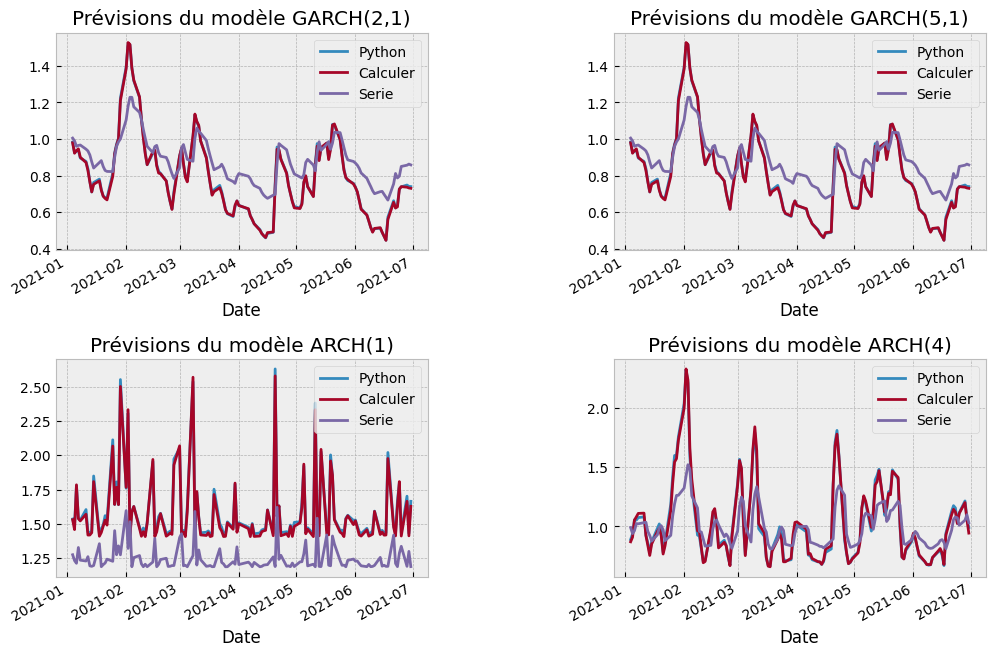

In [33]:
with plt.style.context("bmh"):
    fig = plt.figure(figsize=(12,8))
    layout = (2,2)
    g11_ax = plt.subplot2grid(layout, (0, 0))
    g12_ax = plt.subplot2grid(layout, (0, 1))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    a1_ax = plt.subplot2grid(layout, (1, 0))
    a4_ax = plt.subplot2grid(layout, (1, 1))

    plot_modele(y_true, 2,1,'2020-12-31',ax=g11_ax)
    plot_modele(y_true, 5,1,'2020-12-31',ax=g12_ax) 
    plot_modele(y_true, 1,0,'2020-12-31',ax=a1_ax)
    plot_modele(y_true, 4,0,'2020-12-31',ax=a4_ax)
    plt.show()